### 공공 자전거 수요예측(회귀)

## 목차
**1. About Dataset**

**2. Data Summary**

**3. Feature Engineering**

**4. Missing Value Analysis**

**5. Outlier Analysis**

**6. Correlation Analysis**

**7. Visualizing Distributino of Data**

**8. Visualizing Counts vs (Month, Season, Hour, Weekday, Usertype)**

**9. Filling 0's in Windspeed using Random Forest**

**10. Linear Regression Model**

**11. Regularization Models**

**12. Ensemble Models**

### 1. About Dataset

* datetime : 시간별 날짜 + 타임스탬프
* season :  계절 (1.봄, 2.여름, 3.가을, 4.겨울)
* holiday : 휴일 
* workingday : 근무일 (주말, 휴일이 아닌 날)
* weather : 날씨 (1.맑음/부분적 흐림, 2.안개, 3.눈,비,구름, 4.폭우
* temp : 온도
* atemp : 체감온도
* humidity : 상대 습도
* windspeed :풍속
* casual : 등록되지 않은 사용자의 임대 시작횟수
* registered : 등록된 사용자의 임대 시작횟수
* count : 총 임대수

* Overview
    * 자전거 공유 시스템은 도시 전역의 키오스크 위치망을 통해 회원가입, 대여, 자전거 반납 등의 절차가 자동화된 자전거를 대여하는 수단이다. 이 시스템을 사용하면, 사람들은 한 장소에서 자전거를 빌릴 수 있고 필요에 따라 다른 장소로 자전거를 반납할 수 있다. 현재, 전 세계에는 500여개 이상의 자전거 공유 프로그램이있다.

In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from scipy import stats
from datetime import datetime

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category = DeprecationWarning)
%matplotlib inline

In [2]:
dailyData = pd.read_csv('../data/bike_sharing/train.csv')

### 2. Data Summary

In [3]:
dailyData.shape

(10886, 12)

In [4]:
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [5]:
dailyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
dailyData.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


### 3. Feature Engineering

* ".map"과 dictionary를 이용하면 for loop보다 훨씬 빠르게 데이터 변환을 할 수 있음! 

In [7]:
dailyData['date'] = dailyData.datetime.apply(lambda x: x.split()[0])
dailyData['hour'] = dailyData.datetime.apply(lambda x: x.split()[1].split(":")[0])
dailyData['weekday'] = dailyData.date.apply(lambda x : calendar.day_name[datetime.strptime(x, '%Y-%m-%d').weekday()])
dailyData['month'] = dailyData.date.apply(lambda x : calendar.month_name[datetime.strptime(x, '%Y-%m-%d').month])
dailyData['season'] = dailyData.season.map({1: 'Spring', 2 : 'Summer',
                                            3: 'Fall', 4 : 'Winter'})
dailyData['weather'] = dailyData.weather.map({1 : ' Clear + Few clouds + Partly cloudy',
                                              2 : ' Mist + Clouds, Mist + Broken clouds, Mist + Few clouds, Mist',
                                              3 : ' Light Snow, Light Rain + Thunderstrom + Scattered cloud, Light Rain + Sattered clouds',
                                              4 : ' Heavy Rain + Ice Pallets + Thunderstrom + Mist, Snow + Fog'})

In [8]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy,9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy,9.02,13.635,80,0.0,5,27,32,2011-01-01,02,Saturday,January
3,2011-01-01 03:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy,9.84,14.395,75,0.0,3,10,13,2011-01-01,03,Saturday,January
4,2011-01-01 04:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy,9.84,14.395,75,0.0,0,1,1,2011-01-01,04,Saturday,January


In [9]:
categoryVariableList = ['hour', 'weekday', 'month', 'season',
                        'weather', 'holiday', 'workingday']
for var in categoryVariableList :
    dailyData[var] = dailyData[var].astype('category')

In [10]:
dailyData.drop(['datetime'], axis = 1, inplace = True)

In [11]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index()\
    .rename(columns = {'index' : 'variableType',
                        0 : 'count'})

In [12]:
for i in range(len(dataTypeDf)) :
    dataTypeDf['variableType'][i] = str(dataTypeDf['variableType'][i])

In [13]:
dataTypeDf = pd.DataFrame(dataTypeDf.groupby('variableType')['count'].sum().reset_index())
dataTypeDf.sort_values(by = 'count', ascending = False, inplace = True)
dataTypeDf.head()

,variableType,count
0,category,7
2,int64,4
1,float64,3
3,object,1


* seaborn에서 바로 ascending을 주고 싶을 때는 어떻게 해야하는가?! 

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'variableTypeariable Type'),
 Text(0.5, 1.0, 'Variables DataType Count')]

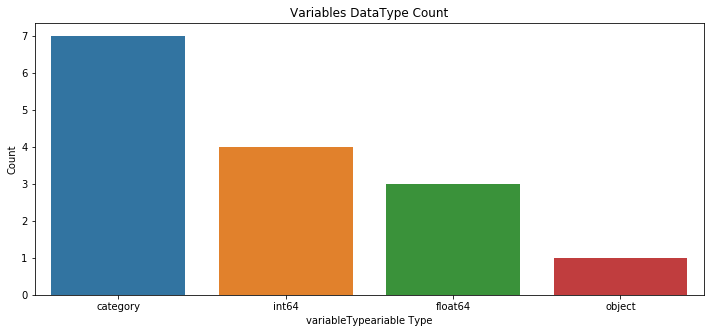

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sns.barplot(data = dataTypeDf, x = 'variableType', y = 'count', ax = ax)
ax.set(xlabel = 'variableTypeariable Type', ylabel = 'Count',
       title = 'Variables DataType Count')

### 4. Missing Values Analysis

* 데이터와 열을 파악한 후에는 일반적으로 우리가 결측치를 가지고 있는지 없는지 보아야한다.운이좋게도 우리는 결측치가 없음을 .info()를 통해 볼 수 있었다. 일반적으로 결측치를 시각화하는 한 가지 방법은 'missingno'를 사용하는 것이다.
* 'missingno'라이브러리는 결측치에 대한 변수를 빠르게 시각화할 수 있는 꽤나 편리한 라이브러리이다.

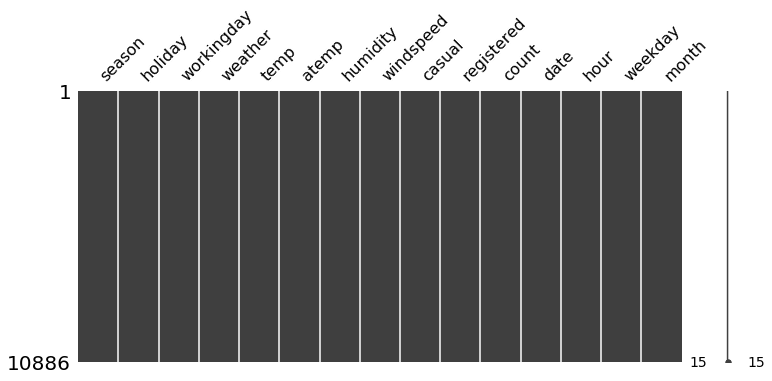

In [15]:
msno.matrix(dailyData, figsize = (12, 5))

### 5. Outliers Analysis

* 처음으로 보는것은 'Count'변수에 분포가 치우쳐져 있음을 알 수 있으며 이를 Boxplot을 이용해서 시각적으로 확인할 수 있다.


* seaborn.boxplot(orient = 'v') 무엇을 뜻하는지 알아보기 

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On COunt Across Working Day')]

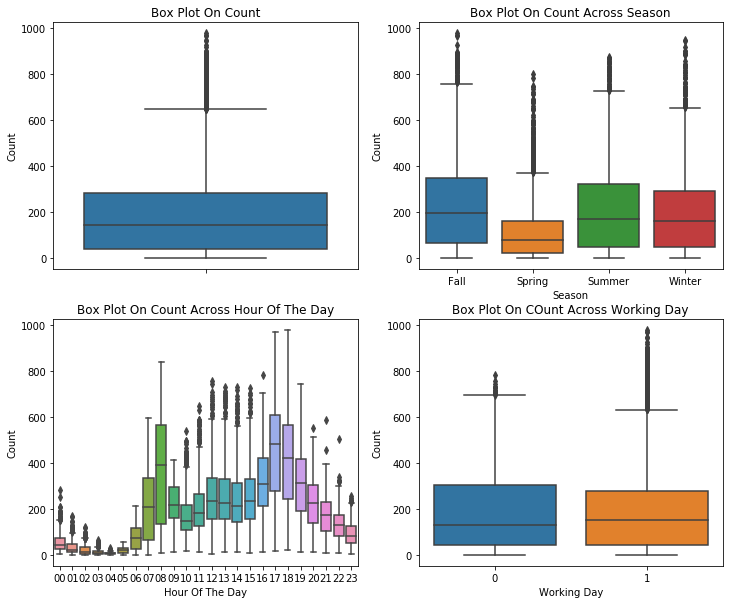

In [16]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(12, 10)
sns.boxplot(data = dailyData, y = 'count', orient = 'v', ax = axes[0][0])
sns.boxplot(data = dailyData, y = 'count', x = 'season', orient = 'v', ax = axes[0][1])
sns.boxplot(data = dailyData, y = 'count', x = 'hour', orient = 'v', ax = axes[1][0])
sns.boxplot(data = dailyData, y = 'count', x = 'workingday', orient = 'v', ax = axes[1][1])

axes[0][0].set(ylabel = 'Count', title = 'Box Plot On Count')
axes[0][1].set(xlabel = 'Season', ylabel = 'Count', title = 'Box Plot On Count Across Season')
axes[1][0].set(xlabel = 'Hour Of The Day', ylabel = 'Count', title = 'Box Plot On Count Across Hour Of The Day')
axes[1][1].set(xlabel = 'Working Day', ylabel = 'Count', title = 'Box Plot On COunt Across Working Day')

* 봄에는 상대적으로 Count가 낮아졌다(중위수 값으로부터 확인할 수 있다.)
* 'Hour Of The Day' 그래프는 무난하며 오전7-8시, 오후5-6시가 높은 것으로 보아 정규 학교와 사무실의 이용자에 의한 것으로 볼 수 있다.
* 대부분의 Outlier은 근무일에 주로 있음을 볼 수 있다.

**Outlier를 지워주도록 하자.** 

In [17]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData['count'] - dailyData['count'].mean()) <=
                                     (3 * dailyData['count'].std())]

In [18]:
print('Shape Of The Before Outliers : ', dailyData.shape)
print('Shape Of The Before Outliers : ', dailyDataWithoutOutliers.shape)

Shape Of The Before Outliers :  (10886, 15)
Shape Of The Before Outliers :  (10739, 15)


### 6. Correlation Analysis

* 종속변수가 어떤 feature에 영향을 받는지를 알아보는 것은 상관행렬을 그림으로써 알수 있다.

In [19]:
corrMatt = dailyData[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']].corr()
corrMatt

,temp,atemp,casual,registered,humidity,windspeed,count
temp,1.000000,0.984948,0.467097,0.318571,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,0.462067,0.314635,-0.043536,-0.057473,0.389784
casual,0.467097,0.462067,1.000000,0.497250,-0.348187,0.092276,0.690414
registered,0.318571,0.314635,0.497250,1.000000,-0.265458,0.091052,0.970948
humidity,-0.064949,-0.043536,-0.348187,-0.265458,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,0.092276,0.091052,-0.318607,1.000000,0.101369
count,0.394454,0.389784,0.690414,0.970948,-0.317371,0.101369,1.000000


In [20]:
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

* np.tril_indices_from의 의미를 알아보자.

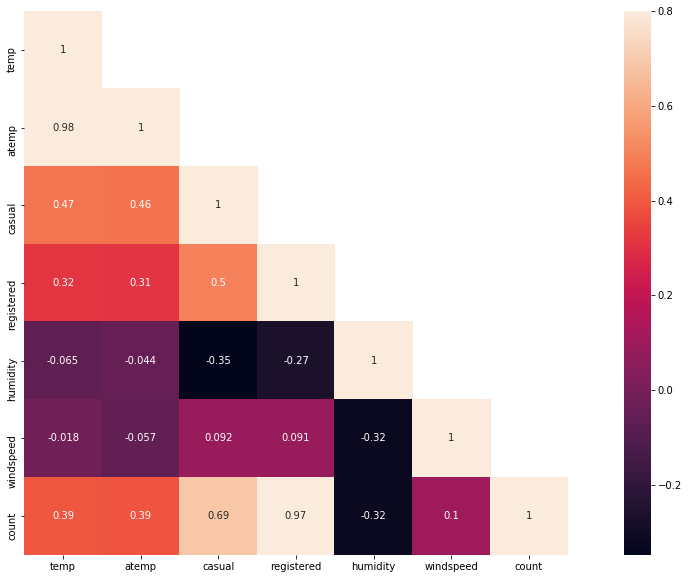

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrMatt, mask = mask, vmax = .8, square = True, annot = True)

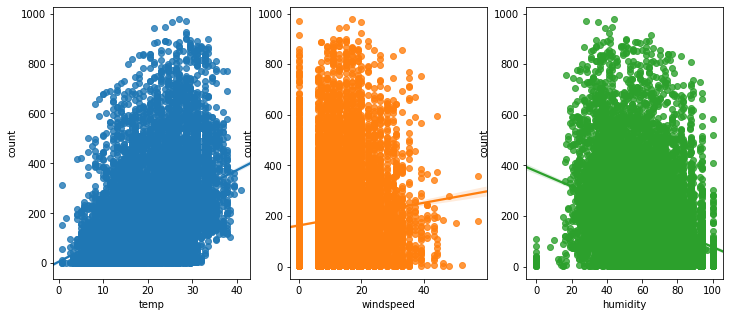

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(12, 5)
sns.regplot(x = 'temp', y = 'count', data = dailyData, ax = ax1)
sns.regplot(x = 'windspeed', y = 'count', data = dailyData, ax = ax2)
sns.regplot(x = 'humidity', y = 'count', data = dailyData, ax = ax3)

* 온도 및 습도는 각각 'Count'와 양의 간계, 음의 관계를 가지고 있다. 하지만, 둘 사이의 관계는 없어보인다.
* 'windspeed'는 'count'와 큰 상관은 없는 것으로 보인다.
* 'atemp'는 'temp'와 강한 상관관계를 가지고 있고, 실제로도 둘이 비슷한 성격을 가지므로 하나의 변수만을 택하기로 한다.
* 'casual'과 'registered'은 또한 'count'변수에 대한 누수변수이기 때문에 고려하지 않도록 한다.

### 7. visualizing Distribution Of Data

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  1,   1,   1, ..., 968, 970, 977], dtype=int64)),
 (169.82942673231383, 191.5741319125482, 0.9372682766213174))

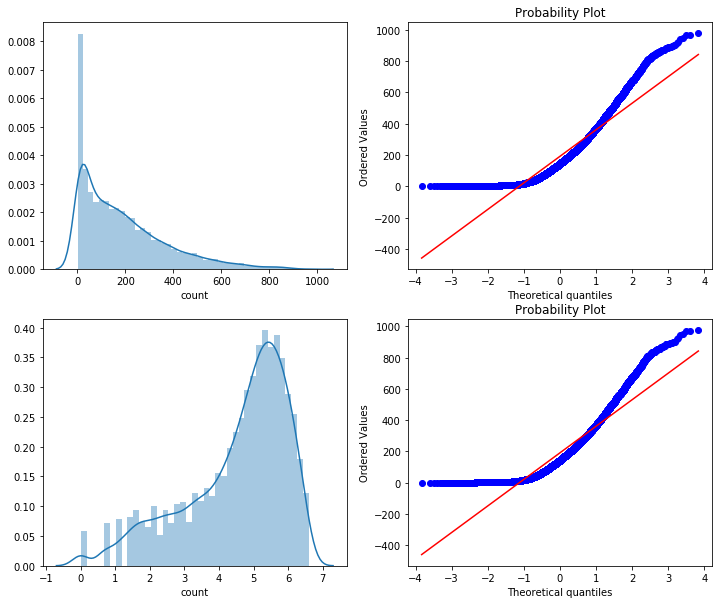

In [23]:
fig, axes = plt.subplots(ncols = 2, nrows = 2)
fig.set_size_inches(12, 10)
sns.distplot(dailyData['count'], ax = axes[0][0])
stats.probplot(dailyData['count'], dist = 'norm', fit = True, plot = axes[0][1])
sns.distplot(np.log(dailyDataWithoutOutliers['count']), ax = axes[1][0])
stats.probplot(dailyData['count'], dist = 'norm', fit = True, plot = axes[1][1])

* 위 그림에서 볼수 있듯이 'count'변수는 왼쪽으로 치우쳐져 있으며, machine learning에 있어서 dependent variable은 정규분포를 따르는 것이 바람직하다. 한 가지 해결책은 outlier들을 제거한 후 log변환을 해주는 것인데 더 나아보이기는 하지만 역시나 정규분포를 만족하지 않고 있다.

### 8. Visualizing Count vs (Month, Season, Hour, Weekday, Usertyype)

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

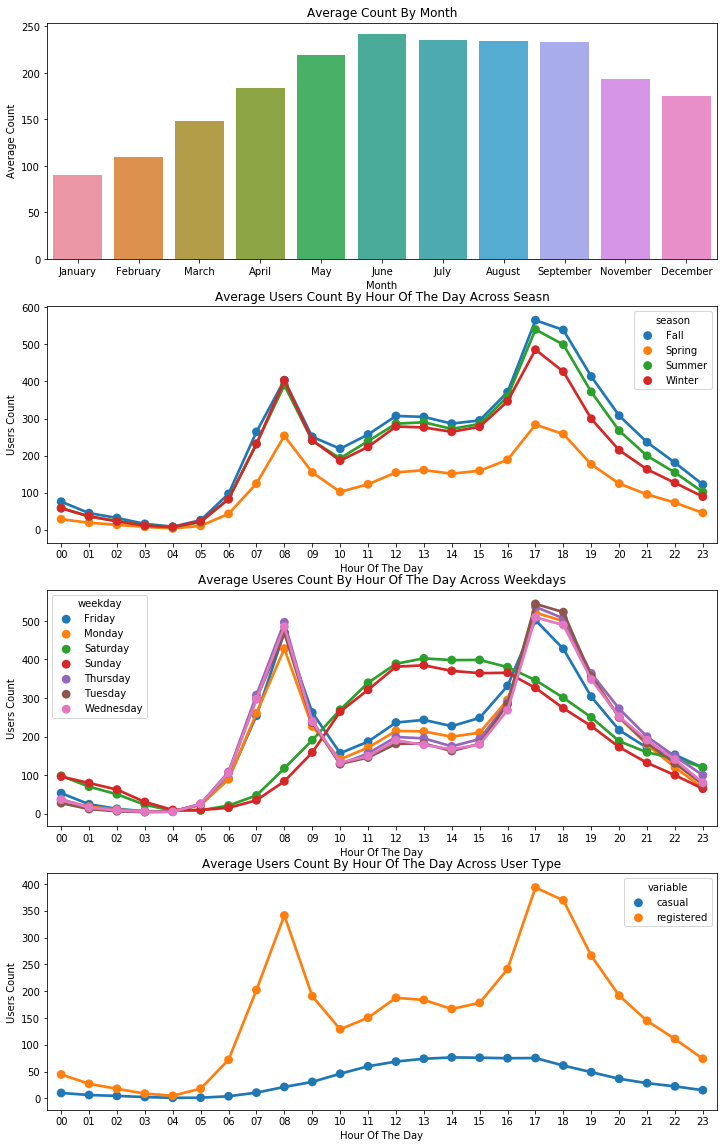

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4)
fig.set_size_inches(12, 20)
sortOrder = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
             'August', 'September', 'November', 'December']
hueOrder = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
            'Friday', 'Satuday']

monthAggregated = pd.DataFrame(dailyData.groupby('month')['count'].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by = 'count', ascending = False)
sns.barplot(data = monthSorted, x = 'month', y = 'count', ax = ax1, order = sortOrder)
ax1.set(xlabel = 'Month', ylabel = 'Average Count', title = 'Average Count By Month')

hourAggregated_season = pd.DataFrame(dailyData.groupby(['hour', 'season'], sort = True)['count'].mean()).reset_index()
sns.pointplot(x = hourAggregated_season['hour'], y = hourAggregated_season['count'], hue = hourAggregated_season['season'],
              data = hourAggregated_season, join = True, ax = ax2)
ax2.set(xlabel = 'Hour Of The Day', ylabel = 'Users Count', title = 'Average Users Count By Hour Of The Day Across Seasn',
        label = 'big')

hourAggregated_weekday = pd.DataFrame(dailyData.groupby(['hour', 'weekday'], sort = True)['count'].mean()).reset_index()
sns.pointplot(x = hourAggregated_weekday['hour'], y = hourAggregated_weekday['count'],
              hue = hourAggregated_weekday['weekday'], data = hourAggregated_weekday,
              join = True, ax = ax3)
ax3.set(xlabel = 'Hour Of The Day', ylabel = 'Users Count', title = 'Average Useres Count By Hour Of The Day Across Weekdays',
        label = 'big')

hourTransformed = pd.melt(dailyData[['hour', 'casual', 'registered']], id_vars = ['hour'], value_vars = ['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(['hour', 'variable'], sort = True)['value'].mean()).reset_index()
sns.pointplot(x = hourAggregated['hour'], y = hourAggregated['value'],
             hue = hourAggregated['variable'], hue_order = ['casual', 'registered'],
              data = hourAggregated, join = True, ax = ax4)
ax4.set(xlabel = 'Hour Of The Day', ylabel = 'Users Count', title = 'Average Users Count By Hour Of The Day Across User Type',
        label = 'big')

* melt함수에 대하여 공부하기

* 첫 번째 그래프로부터 여름시즌에 자전거를 빌리는 경향이 상대적으로 더 많아졌음을 알 수 있다.
* 출퇴근시간에 자전거를 빌리는 사람이 많아졌다.
* 2번째 패턴은 '주말'에는 관찰되지 않으며, 주말에는 10~16시사이에 빌리는 경향성이 있음을 알 수 있다.


## Modeling

### 9. Filling 0's In windspeed Using Random Forest

In [25]:
dataTrain = pd.read_csv('../data/bike_sharing/train.csv')
dataTest = pd.read_csv('../data/bike_sharing/test.csv')

In [26]:
data = dataTrain.append(dataTest)
data.reset_index(drop = True, inplace =True)

C:\anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


#### Feature Engineering

In [27]:
data['date'] = data.datetime.apply(lambda x: x.split()[0])
data['hour'] = data.datetime.apply(lambda x: x.split()[1].split(":")[0]).astype('int')
data['year'] = data.datetime.apply(lambda x: x.split()[0].split('-')[0])
data['weekday'] = data.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())
data['month'] = data.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)

#### Random Forest Model to Predict 0's in Windspeed

In [28]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data['windspeed'] == 0]
dataWindNot0 = data[data['windspeed'] != 0]
rfModel_wind = RandomForestRegressor()
windColumns = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0['windspeed'])

wind0Values = rfModel_wind.predict(X = dataWind0[windColumns])
dataWind0['windspeed'] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(drop = True, inplace =True)

In [29]:
data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,year,weekday,month
0,12.880,0.0,1.0,2011-01-01 05:00:00,0,75,1.0,1,9.84,2,6.0032,0,2011-01-01,5,2011,5,1
1,19.695,12.0,36.0,2011-01-01 10:00:00,0,76,24.0,1,15.58,1,16.9979,0,2011-01-01,10,2011,5,1
2,16.665,26.0,56.0,2011-01-01 11:00:00,0,81,30.0,1,14.76,1,19.0012,0,2011-01-01,11,2011,5,1
3,21.210,29.0,84.0,2011-01-01 12:00:00,0,77,55.0,1,17.22,1,19.0012,0,2011-01-01,12,2011,5,1
4,22.725,47.0,94.0,2011-01-01 13:00:00,0,72,47.0,1,18.86,2,19.9995,0,2011-01-01,13,2011,5,1


#### Coercing To Categorical Type

In [30]:
categoricalFeatureNames = ['season', 'holiday', 'workingday', 'weather',
                          'weekday', 'month', 'year', 'hour']
numericalFeatureNames = ['temp', 'humidity', 'windspeed', 'atemp']
dropFeatures = ['casual', 'count', 'datetime', 'date', 'registered']

In [31]:
for var in categoricalFeatureNames :
    data[var] = data[var].astype('category')

#### Splitting Train And Test Data

In [32]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by = ['datetime'])
dataTest = data[~pd.notnull(data['count'])].sort_values(by = ['datetime'])
datetimecol = dataTest['datetime']
yLabels = dataTrain['count']
yLablesRegistered = dataTrain['registered']
yLablesCasual = dataTrain['casual']

#### Dropping Unnecessary Variables

In [33]:
dataTrain = dataTrain.drop(dropFeatures, axis = 1)
dataTest = dataTest.drop(dropFeatures, axis = 1)

#### RMSLE Scors

In [34]:
def rmsle(y, y_, convertExp = True) :
    if convertExp :
        y = np.exp(y)
        y_ = np.exp(y_)
        
    log1 = np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc = (log1 - log2) ** 2
    
    return np.sqrt(np.mean(calc))

### 10. Linear Regression Model

In [40]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category = DeprecationWarning)

lModel = LinearRegression()
yLabelsLog = np.log1p(yLabels)

lModel.fit(X = dataTrain, y = yLabelsLog)
preds = lModel.predict(X = dataTrain)
print('RMSLE Value For Linear Regression : ',
     rmsle(np.exp(yLabelsLog), np.exp(preds), False))

RMSLE Value For Linear Regression :  0.977964794590437


### 11. Regularization Model - Ridge

In [45]:
grid_ridge_m.param_grid

{'max_iter': [3000],
 'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression :  0.9779647795272018


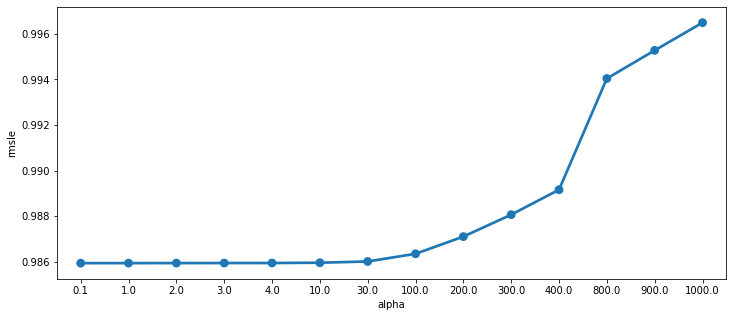

In [46]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter' : [3000], 'alpha' : [0.1, 1, 2, 3, 4, 10, 30, 100,
                                                  200, 300, 400, 800, 900, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
grid_ridge_m = GridSearchCV( ridge_m_,
                           ridge_params_,
                           scoring = rmsle_scorer,
                           cv = 5)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit( dataTrain, yLabelsLog)
preds = grid_ridge_m.predict(X = dataTrain)
print(grid_ridge_m.best_params_)
print('RMSLE Value For Ridge Regression : ',
     rmsle(np.exp(yLabelsLog), np.exp(preds), False))

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df = df[['mean_test_score', 'std_test_score', 'params']]
df['alpha'] = df['params'].apply(lambda x: x['alpha'])
df['rmsle'] = df['mean_test_score'].apply(lambda x: -x)
sns.pointplot(data = df, x = 'alpha', y = 'rmsle', ax = ax)

### 12. Regularization Model - Lasso

{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value For Lasso Regression :  0.9781024641606799


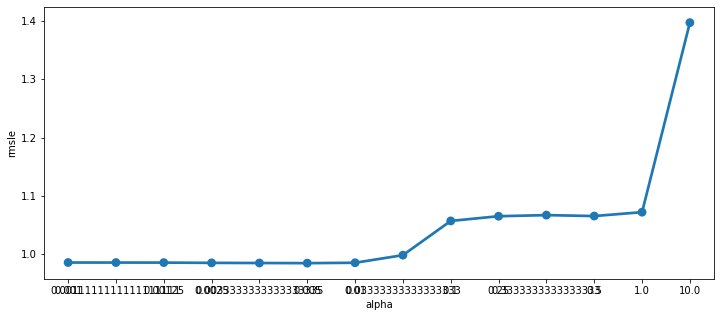

In [47]:
lasso_m_ = Lasso()

alpha = 1 / np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300,
                      400, 800, 900, 1000])
lasso_params_ = { 'max_iter' : [3000], 'alpha' : alpha}

grid_lasso_m = GridSearchCV(lasso_m_,
                           lasso_params_,
                           scoring = rmsle_scorer,
                           cv = 5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit(dataTrain, yLabelsLog)
preds = grid_lasso_m.predict(X = dataTrain)
print( grid_lasso_m.best_params_)
print('RMSLE Value For Lasso Regression : ',
     rmsle(np.exp(yLabelsLog), np.exp(preds), False))

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
df = df[['mean_test_score', 'std_test_score', 'params']]
df['alpha'] = df['params'].apply(lambda x: x['alpha'])
df['rmsle'] = df['mean_test_score'].apply(lambda x: -x)
sns.pointplot(data = df, x = 'alpha', y = 'rmsle', ax = ax)

### Ensemble Models - Random Forest

In [48]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators = 100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain, yLabelsLog)
preds = rfModel.predict(X = dataTrain)
print('RMSLE Value For Random Forest : ', 
     rmsle(np.exp(yLabelsLog), np.exp(preds), False))

RMSLE Value For Random Forest :  0.1030668632033741


### Ensemble Model - Gradient Boost

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators = 4000, alpha = 0.01);
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain, yLabelsLog)
preds = gbm.predict(X = dataTrain)
print('RMSLE Value For Gradient Boost : ',
     rmsle(np.exp(yLabelsLog), np.exp(preds), False))

RMSLE Value For Gradient Boost :  0.18959569337514323


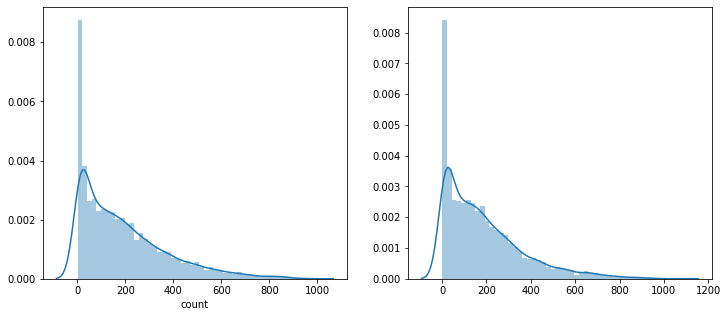

In [50]:
predsTest = gbm.predict(X = dataTest)
fig, (ax1, ax2) = plt.subplots(ncols = 2)
fig.set_size_inches(12, 5)
sns.distplot(yLabels, ax = ax1, bins = 50)
sns.distplot(np.exp(predsTest), ax = ax2, bins = 50)